In [1]:
import glob
import os
import re
import scipy
import pathlib
import pandas as pd
import time
import collections
import itertools
import pickle
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels
import json
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [2]:
def extract_features(file):
    #get wave representation
    y, sr = librosa.load(file)
        
    #Mel-frequency cepstral coefficients (MFCCs)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13),axis=1)
    #mel-scaled spectrogram
    spectrogram = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000),axis=1)
    #compute spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr),axis=1)
    
    return [mfcc, spectrogram, contrast] # chroma, rolloff, centroid, zero, harmonic

In [3]:
def custom_plot_cm(y_true, y_pred, labels, title, normalize=False, cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Optional normalization
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')
    #print(cm)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # Define unique labels
    #labels = labels[unique_labels(y_true, y_pred)]
    # Set ticks and labels
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=labels, yticklabels=labels,
           title=title, ylabel='True label', xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    return ax

In [4]:
def family_from_name(filename):
    class_names=['bass', 'brass', 'flute', 'guitar', 'keyboard', 'mallet', 
                 'organ', 'reed', 'string', 'synth_lead', 'vocal']

    for name in class_names:
        if name in str(filename):
            return name
    else:
        return None

In [5]:
def code_from_name(filename):
    class_names=['bass', 'brass', 'flute', 'guitar', 'keyboard', 'mallet', 
                 'organ', 'reed', 'string', 'vocal']

    for name in class_names:
        if name in str(filename):
            return class_names.index(name)
    else:
        return None

In [19]:
def load_data(df_features, test_size = 0.1, validation_size = 0.1):
  X = np.array(df_features.drop(labels=['targets'], axis=1))
  y = np.array(df_features['targets'])
  X = np.expand_dims(X, -1)
  y = np.expand_dims(y, -1)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
  X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
  return X_train, X_validation, X_test, y_train, y_validation, y_test

In [ ]:
def build_model(nodes, shape):
  
  model = keras.Sequential()

  # 2 LSTM layers
  model.add(keras.layers.LSTM(nodes, input_shape=shape, return_sequences=True))
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.LSTM(nodes))
  model.add(keras.layers.Dropout(0.2))
  
  # dense layer
  model.add(keras.layers.Dense(nodes, activation='relu'))
  model.add(keras.layers.Dropout(0.3))

  # output layer
  model.add(keras.layers.Dense(10, activation='softmax'))

  return model

# Model

## Data Prep

In [ ]:
#read the json file for validation set
df_train_raw = pd.read_json(path_or_buf='/content/drive/My Drive/MATH189-big-data/train.json', orient='index')
# visualize data distribution
df_train_raw['instrument_family_str'].value_counts().plot(kind = 'bar')
plt.title("Instrument Family Distribution of Dataset")
plt.xlabel('Instrument Family')
plt.ylabel('Number of Samples')
plt.show()
print(df_train_raw['instrument_family_str'].value_counts())

In [265]:
#Sample 5500 files, group by instrument family
df_train_sample=df_train_raw.groupby('instrument_family', as_index=False, group_keys=False).apply(lambda df: df.sample(1000))
#drop the synth_lead from the training dataset
df_train_sample= df_train_sample[df_train_sample['instrument_family']!=9]
#save the train file index (filenames) as pickle file
filenames_train = df_train_sample.index.tolist()
with open('/content/drive/My Drive/MATH189-big-data/sav-files/filenames_train.pickle', 'wb') as f:
    pickle.dump(filenames_train, f)

In [ ]:
if __name__ == "__main__":
  #read the json file for validation set
  df_train_raw = pd.read_json(path_or_buf='/content/drive/My Drive/MATH189-big-data/train.json', orient='index')
  #Sample 5500 files, group by instrument family
  df_train_sample=df_train_raw.groupby('instrument_family', as_index=False, group_keys=False).apply(lambda df: df.sample(1000))
  #drop the synth_lead from the training dataset
  df_train_sample= df_train_sample[df_train_sample['instrument_family']!=9]
  #save the train file index (filenames) as pickle file
  filenames_train = df_train_sample.index.tolist()
  with open('/content/drive/My Drive/MATH189-big-data/sav-files/filenames_train.pickle', 'wb') as f:
      pickle.dump(filenames_train, f)
  #create dictionary to store all train sample features
  train_dir = '/content/drive/My Drive/MATH189-big-data/train/'
  dict_train = {}
  for file in filenames_train:
      features = extract_features(train_dir + file + '.wav')
      dict_train[file] = features
  # create dataframe from dictionary
  features_train = pd.DataFrame.from_dict(dict_train, orient='index',
                                        columns=['mfcc', 'spectro', 'contrast'])
  #extract mfccs
  mfcc_train = pd.DataFrame(features_train.mfcc.values.tolist(),index=features_train.index).add_prefix('mfcc')
  #extract spectro
  spectro_trainl = pd.DataFrame(features_train.spectro.values.tolist(),index=features_train.index).add_prefix('spectro')
  #extract contrast
  contrast_train = pd.DataFrame(features_train.contrast.values.tolist(),index=features_train.index).add_prefix('contrast')
  #drop the old columns
  features_val = features_val.drop(labels=['mfcc', 'spectro', 'contrast'], axis=1)
  #concatenate
  df_features_val=pd.concat([features_val, mfcc_val, spectro_val, contrast_val],axis=1, join='inner')
  df_features_val.head()

  targets_train = []
  for name in df_features_train.index.tolist():
    targets_train.append(family_from_name(name))

  df_features_train['targets'] = targets_train
  # save the dataframe to a pickle file
  df_features_val0 = df_features_val
  with open('/content/drive/My Drive/MATH189-big-data/sav-files/df_features_train0.pickle', 'wb') as f:
      pickle.dump(df_features_train0, f)

## ML Modeling

In [6]:
# open dataframe
# df_features_val0: initial results with 400 samples form each validation instrument family
with open('/content/drive/My Drive/MATH189-big-data/sav-files/df_features_nonsynth.pickle', 'rb') as f:
    df_val = pickle.load(f)
df_val.head()

,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,spectro0,spectro1,spectro2,spectro3,spectro4,spectro5,spectro6,spectro7,spectro8,spectro9,spectro10,spectro11,spectro12,spectro13,spectro14,spectro15,spectro16,spectro17,spectro18,spectro19,spectro20,spectro21,spectro22,spectro23,spectro24,spectro25,spectro26,...,spectro96,spectro97,spectro98,spectro99,spectro100,spectro101,spectro102,spectro103,spectro104,spectro105,spectro106,spectro107,spectro108,spectro109,spectro110,spectro111,spectro112,spectro113,spectro114,spectro115,spectro116,spectro117,spectro118,spectro119,spectro120,spectro121,spectro122,spectro123,spectro124,spectro125,spectro126,spectro127,contrast0,contrast1,contrast2,contrast3,contrast4,contrast5,contrast6,targets
bass_electronic_019-056-100,-475.289825,80.809853,33.530380,15.548780,4.014418,-1.022044,-6.070887,-3.788300,-6.156924,-8.998531,-10.564408,-10.077577,-7.313849,0.288006,0.288575,1.233198,1.066746,1.058999,2.629608,1.081414,84.704765,306.970398,30.619595,0.165982,0.302577,0.148403,0.143815,0.592450,0.589053,36.419056,106.267769,2.512952,0.012056,0.019833,0.065555,0.033962,0.109455,0.281720,17.973963,30.911015,...,1.969599e-05,7.618379e-04,2.347358e-04,1.388626e-04,1.185183e-04,5.297616e-05,7.526729e-05,1.555204e-05,1.938112e-05,8.632464e-06,2.156434e-05,3.585257e-05,1.930463e-04,3.668198e-05,4.387155e-05,3.677531e-05,4.717466e-05,1.780584e-04,8.462439e-05,1.173886e-04,2.759363e-05,3.074252e-05,3.857559e-05,3.309901e-05,5.027738e-05,3.502059e-05,4.159845e-05,7.980366e-05,1.414238e-04,2.146546e-05,1.412099e-06,4.559440e-09,23.555460,31.804107,34.819774,33.770990,25.472569,19.936401,39.865841,bass
bass_electronic_033-045-075,-288.977661,93.734993,-3.971388,56.851620,9.399693,18.284504,-0.034838,5.712360,6.690342,-2.634700,5.201155,-7.455999,-3.448792,1.305197,4.137875,9.878888,498.016541,999.795166,31.945738,0.911212,12.129009,890.297119,648.789612,5.689907,1.637718,2.303212,17.421347,4.888461,0.116710,0.045269,5.731268,19.418997,1.528157,0.270254,0.122133,2.136333,2.251666,0.066282,0.067668,0.274242,...,4.278518e-02,4.115182e-02,3.930552e-02,1.982398e-02,1.808195e-02,1.651363e-02,1.589069e-02,2.016027e-02,1.745234e-02,1.372221e-02,1.089260e-02,1.079919e-02,1.611810e-02,1.505650e-02,1.174242e-02,1.005707e-02,1.193317e-02,1.355269e-02,1.479201e-02,1.128394e-02,7.797263e-03,6.101118e-03,4.441814e-03,3.594024e-03,2.767158e-03,1.283353e-03,7.059217e-04,6.313984e-04,4.814576e-04,1.000232e-04,4.627070e-06,9.833994e-09,29.935366,29.842846,24.913389,23.326742,19.945098,18.281537,56.657160,bass
bass_electronic_012-028-025,-558.471924,8.224245,4.972193,3.708537,3.400621,2.658243,1.836772,1.297053,0.903076,0.658811,0.538436,0.417854,0.341084,3.805831,8.450940,8.640702,2.421245,11.425265,2.378835,1.088978,1.070887,0.255536,0.074412,0.072323,0.446369,0.099814,0.150197,0.141186,0.016849,0.018376,0.014399,0.004270,0.001497,0.007463,0.005508,0.006341,0.004436,0.003469,0.000968,0.000746,...,1.526352e-07,4.429647e-08,5.243550e-08,1.376288e-07,2.026280e-07,6.912277e-08,2.328427e-07,1.732543e-07,1.370153e-07,2.989267e-08,1.016423e-07,1.577717e-07,7.054951e-08,2.596845e-07,3.293173e-07,1.005795e-07,2.121971e-08,3.142733e-08,2.149634e-08,2.153160e-08,3.384397e-08,6.536359e-08,5.034135e-08,2.639618e-08,1.365536e-08,1.561204e-08,2.423554e-08,1.436620e-08,1.244431e-08,8.675845e-09,9.019058e-10,2.839244e-11,12.538894,12.415962,12.448481,12.466767,12.404780,12.201792,14.836701,bass
bass_electronic_014-022-075,-497.518066,-0.874968,-6.461961,16.271271,0.084050,-4.549519,7.596972,3.369718,-4.123587,3.120336,4.321723,-4.599898,0.903132,0.413644,6.883932,40.901070,34.210739,9.172524,11.256470,2.670516,0.711608,0.733901,0.845303,0.756205,0.194777,0.120734,0.064957,0.068568,0.056379,0.032048,0.016174,0.002793,0.002064,0.001796,0.001395,0.000834,0.000481,0.000289,0.000227,0.000186,...,3.076953e-03,5.090501e-04,5.609036e-05,7.746821e-05,1.606406e-04,3.526094e-04,4.926127e-04,2.478211e-04,1.043855e-04,5.6659

In [7]:
features = df_val.drop(labels=['targets'], axis=1)
labels = df_val['targets']
(X_train, X_test, y_train, y_test) = train_test_split(features, labels, test_size = 0.10, 
                                                     stratify = labels, random_state=30)

The accuracy of Random Forest is 87.68%


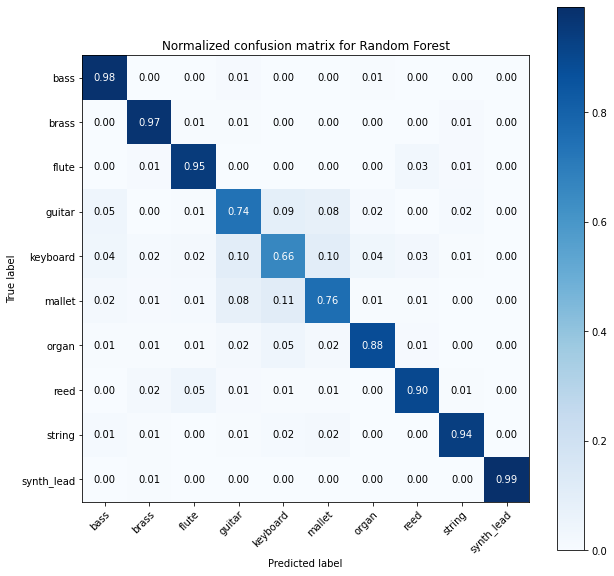

In [11]:
labels=np.array(['bass', 'brass', 'flute', 'guitar', 
             'keyboard', 'mallet', 'organ', 'reed', 
             'string', 'synth_lead', 'vocal'])
#instantiate the random forest
clf_Rf =RandomForestClassifier(n_estimators=20, max_depth=50, warm_start=True)
clf_Rf.fit(X_train, y_train)
y_pred_RF = clf_Rf.predict(X_test)
accuracy_RF = np.mean(y_pred_RF == y_test)
print("The accuracy of Random Forest is {0:.2%}".format(accuracy_RF))
custom_plot_cm(y_test, y_pred_RF, labels, 'Normalized confusion matrix for Random Forest', normalize=True)
#plot_confusion_matrix(clf_Rf, X_test, y_test, labels=None, normalize='true',  display_labels=labels, xticks_rotation=45, values_format=None, cmap=plt.cm.Blues, ax=None)

In [13]:

labels=np.array(['bass', 'brass', 'flute', 'guitar', 
             'keyboard', 'mallet', 'organ', 'reed', 
             'string', 'vocal'])
classification_report(y_test, y_pred_RF, target_names=labels)

'              precision    recall  f1-score   support\n\n        bass       0.42      0.48      0.45       100\n       brass       0.77      0.89      0.83       100\n       flute       0.75      0.80      0.77       100\n      guitar       0.46      0.44      0.45       100\n    keyboard       0.43      0.41      0.42       100\n      mallet       0.49      0.48      0.48       100\n       organ       0.82      0.72      0.77       100\n        reed       0.76      0.68      0.72       100\n      string       0.78      0.76      0.77       100\n       vocal       0.78      0.80      0.79       100\n\n    accuracy                           0.65      1000\n   macro avg       0.65      0.65      0.65      1000\nweighted avg       0.65      0.65      0.65      1000\n'

## CNN Modeling

In [21]:
# open dataframe
with open('/content/drive/My Drive/MATH189-big-data/sav-files/df_features_train0.pickle', 'rb') as f:
  df_val = pickle.load(f)
df_features = df_val.drop(labels=['targets'], axis=1)
targets_code = []
for name in df_features.index.tolist():
  targets_code.append(code_from_name(name))
df_features['targets'] = targets_code

In [23]:
size = df_features.shape[0]
test_size = 0.1
validation_size = 0.1
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test = load_data(df_features)
nodes = 100 #size/(alpha*(147+10))

# create network
shape = (X_train.shape[1], X_train.shape[2])
model = build_model(nodes, shape)
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 148, 100)          40800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 148, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [24]:
# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100)

Epoch 1/100
254/254 [==============================] - 62s 244ms/step - loss: 2.2416 - accuracy: 0.1556 - val_loss: 2.1424 - val_accuracy: 0.2244
Epoch 2/100
254/254 [==============================] - 66s 259ms/step - loss: 2.0401 - accuracy: 0.2442 - val_loss: 1.9805 - val_accuracy: 0.2944
Epoch 3/100
254/254 [==============================] - 67s 265ms/step - loss: 1.9600 - accuracy: 0.2763 - val_loss: 1.8774 - val_accuracy: 0.3478
Epoch 4/100
254/254 [==============================] - 66s 261ms/step - loss: 1.8968 - accuracy: 0.3098 - val_loss: 1.7840 - val_accuracy: 0.3644
Epoch 5/100
254/254 [==============================] - 66s 262ms/step - loss: 1.8456 - accuracy: 0.3263 - val_loss: 1.7638 - val_accuracy: 0.3856
Epoch 6/100
254/254 [==============================] - 67s 263ms/step - loss: 1.7878 - accuracy: 0.3641 - val_loss: 1.7101 - val_accuracy: 0.4044
Epoch 7/100
254/254 [==============================] - 66s 262ms/step - loss: 1.7120 - accuracy: 0.3935 - val_loss: 1.6363 -

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
0.698
The accuracy of LSTM is 69.80%


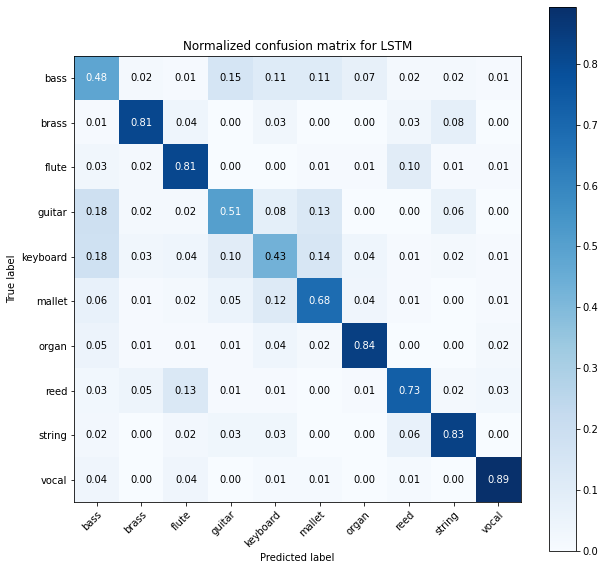

In [26]:
labels=np.array(['bass', 'brass', 'flute', 'guitar', 
             'keyboard', 'mallet', 'organ', 'reed', 
             'string', 'vocal'])
y_pred = model.predict_classes(X_test)
accuracy = np.mean(y_pred == y_test[:,0])
print(accuracy)
print("The accuracy of LSTM is {0:.2%}".format(accuracy))
custom_plot_cm(y_test, y_pred, labels, 'Normalized confusion matrix for LSTM', normalize=True)

In [27]:
classification_report(y_test, y_pred, target_names=labels)

'              precision    recall  f1-score   support\n\n        bass       0.44      0.48      0.46       100\n       brass       0.84      0.81      0.82       100\n       flute       0.71      0.81      0.76       100\n      guitar       0.58      0.51      0.54        99\n    keyboard       0.49      0.43      0.46       100\n      mallet       0.64      0.68      0.66       111\n       organ       0.83      0.84      0.84       100\n        reed       0.77      0.73      0.75       111\n      string       0.79      0.83      0.81        95\n       vocal       0.89      0.89      0.89        84\n\n    accuracy                           0.70      1000\n   macro avg       0.70      0.70      0.70      1000\nweighted avg       0.70      0.70      0.70      1000\n'